In [1]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pickle
from scipy.stats import uniform
import copy
from datetime import datetime, timedelta

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

import warnings

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *


# Preparación de los datos

In [2]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Ruido_diario_acumulado.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [3]:
# Se obtienen los datos
df_acoustics = pd.read_csv('data/raw/Ruido_diario_acumulado.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


389519

In [4]:
# Se borran los datos no necesarios
df_acoustics = df_acoustics.drop(columns=['LAEQ', 'LAS01', 'LAS10', 'LAS90', 'LAS99'])

df_acoustics.head()


,NMT,anio,mes,dia,tipo,LAS50
0,3,2014,1,1,D,"54,3"
1,3,2014,1,1,E,56
2,3,2014,1,1,N,"60,9"
3,3,2014,1,1,T,"56,5"
4,4,2014,1,1,D,"63,2"


In [5]:
# Se mantiene solo el tipo "T", que representa el total del día
df_acoustics = df_acoustics.drop(df_acoustics[df_acoustics['tipo'] != 'T'].index)

df_acoustics = df_acoustics.drop(columns='tipo')

df_acoustics.head()


,NMT,anio,mes,dia,LAS50
3,3,2014,1,1,"56,5"
7,4,2014,1,1,"63,9"
11,5,2014,1,1,"58,6"
15,8,2014,1,1,"65,2"
19,10,2014,1,1,"58,7"


In [6]:
for date in df_acoustics.columns[1:-1]:
    df_acoustics[date] = list(map(str, df_acoustics[date]))

df_acoustics['date'] = df_acoustics['anio'] + '-' + df_acoustics['mes'] + '-' + df_acoustics['dia']

df_acoustics = df_acoustics.drop(columns=['anio', 'mes', 'dia'])

df_acoustics.head()


,NMT,LAS50,date
3,3,"56,5",2014-1-1
7,4,"63,9",2014-1-1
11,5,"58,6",2014-1-1
15,8,"65,2",2014-1-1
19,10,"58,7",2014-1-1


In [7]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['date'] = pd.to_datetime(df_acoustics['date'])

df_acoustics = df_acoustics.set_index('date')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20'],
              dtype='datetime64[ns]', name='date', length=97522, freq=None)

In [8]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics['LAS50'] = df_acoustics['LAS50'].astype(str)

for col in df_acoustics.columns[1:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = pd.to_numeric(df_acoustics[col], errors='coerce')
    df_acoustics[col] = df_acoustics[col].astype(float)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97522 entries, 2014-01-01 to 2023-03-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NMT     97522 non-null  int64  
 1   LAS50   97522 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [9]:
# Se pivota la tabla para que cada columna sea una zona
df_acoustics = df_acoustics.pivot_table(index='date', columns='NMT', values='LAS50')

df_acoustics.head()


NMT,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,56.5,63.9,58.6,NaN,65.2,58.7,65.4,60.3,...,60.0,49.0,51.9,52.6,47.8,60.3,NaN,56.2,48.1,50.5
2014-01-02,NaN,NaN,58.0,64.8,60.0,NaN,67.5,61.7,69.1,62.7,...,62.8,51.2,59.7,58.9,51.0,62.7,NaN,60.9,51.6,54.3
2014-01-03,NaN,NaN,58.6,64.7,60.0,NaN,67.2,61.9,69.1,62.4,...,63.5,52.6,58.5,58.9,50.5,62.7,NaN,60.6,50.9,54.0
2014-01-04,NaN,NaN,59.0,64.2,59.3,NaN,67.1,60.3,67.4,61.7,...,61.9,50.4,55.8,60.0,51.1,62.0,NaN,60.1,50.9,52.8
2014-01-05,NaN,NaN,58.0,63.4,57.8,NaN,64.9,58.9,66.1,60.5,...,59.8,48.7,52.7,56.9,47.1,60.1,NaN,58.3,47.9,50.5


In [10]:
# Se establece la frecuencia "D" (diaria)
df_acoustics = df_acoustics.asfreq('D')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       2820 non-null   float64
 1   2       2902 non-null   float64
 2   3       3243 non-null   float64
 3   4       2456 non-null   float64
 4   5       3279 non-null   float64
 5   6       2884 non-null   float64
 6   8       3218 non-null   float64
 7   10      3254 non-null   float64
 8   11      3206 non-null   float64
 9   12      3276 non-null   float64
 10  13      3274 non-null   float64
 11  14      3209 non-null   float64
 12  16      3190 non-null   float64
 13  17      3261 non-null   float64
 14  18      3257 non-null   float64
 15  19      3168 non-null   float64
 16  20      3234 non-null   float64
 17  24      3246 non-null   float64
 18  25      2869 non-null   float64
 19  26      2869 non-null   float64
 20  27      3216 non-null   float64
 21  28      327

In [11]:
# El resto, con una interpolación. Sigue habiendo nulos
df_acoustics = df_acoustics.interpolate(method='spline', order=3)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3001 non-null   float64
 1   2       3000 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3000 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3001 non-null   float64
 19  26      3001 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

In [12]:
# Se imputan los restantes con los vecinos cercanos
imputer = KNNImputer(n_neighbors=5)

imputer.fit(df_acoustics)

df_acoustics = pd.DataFrame(imputer.transform(df_acoustics), columns=df_acoustics.columns, index=df_acoustics.index)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3366 non-null   float64
 1   2       3366 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3366 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3366 non-null   float64
 19  26      3366 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

# ML

## Preparación

### Prueba

#### Preparación

In [39]:
# Se selecciona solo el primer barrio
df_uno = df_acoustics[[1]]

df_uno.head()


NMT,1
date,
2014-01-01,64.60
2014-01-02,66.62
2014-01-03,66.82
2014-01-04,65.66
2014-01-05,64.26


In [40]:
# Se le cambia el nombre
df_uno = df_uno.rename(columns={1: 'x'})

df_uno.head()


NMT,x
date,
2014-01-01,64.60
2014-01-02,66.62
2014-01-03,66.82
2014-01-04,65.66
2014-01-05,64.26


In [41]:
# Se crean columnas sucesivas que incluyen los decibelios de las fechas anteriores para cada índice
n = len(df_uno)

for i in range(n+1):
    df_uno[f'x-{i}'] = df_uno['x'].shift(i)

df_uno


C:\Users\Roger\AppData\Local\Temp\ipykernel_6032\635945192.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_uno[f'x-{i}'] = df_uno['x'].shift(i)
C:\Users\Roger\AppData\Local\Temp\ipykernel_6032\635945192.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_uno[f'x-{i}'] = df_uno['x'].shift(i)
C:\Users\Roger\AppData\Local\Temp\ipykernel_6032\635945192.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

NMT,x,x-0,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,...,x-3357,x-3358,x-3359,x-3360,x-3361,x-3362,x-3363,x-3364,x-3365,x-3366
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,64.60,64.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,66.62,66.62,64.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,66.82,66.82,66.62,64.60,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,65.66,65.66,66.82,66.62,64.60,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,64.26,64.26,65.66,66.82,66.62,64.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16,62.00,62.00,61.90,61.30,61.00,60.3,61.6,62.2,62.9,62.2,...,64.260000,65.660000,66.820000,66.62,64.60,NaN,NaN,NaN,NaN,NaN
2023-03-17,62.00,62.00,62.00,61.90,61.30,61.0,60.3,61.6,62.2,62.9,...,64.440000,64.260000,65.660000,66.82,66.62,64.60,NaN,NaN,NaN,NaN
2023-03-18,60.60,60.60,62.00,62.00,61.90,61.3,61.0,60.3,61.6,62.2,...,65.838602,64.440000,64.260000,65.66,66.82,66.62,64.60,NaN,NaN,NaN


In [43]:
# Se ordenan de mas reciente a mas antiguo
df_uno = df_uno.sort_index(ascending=False)
df_uno = df_uno.drop(columns='x-0')

df_uno.head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,...,x-3357,x-3358,x-3359,x-3360,x-3361,x-3362,x-3363,x-3364,x-3365,x-3366
date,,,,,,,,,,,,,,,,,,,,,
2023-03-20,58.50,59.00,60.60,62.00,62.0,61.9,61.3,61.0,60.3,61.6,...,65.960000,65.640000,65.838602,64.44,64.26,65.66,66.82,66.62,64.6,NaN
2023-03-19,59.00,60.60,62.00,62.00,61.9,61.3,61.0,60.3,61.6,62.2,...,65.640000,65.838602,64.440000,64.26,65.66,66.82,66.62,64.60,NaN,NaN
2023-03-18,60.60,62.00,62.00,61.90,61.3,61.0,60.3,61.6,62.2,62.9,...,65.838602,64.440000,64.260000,65.66,66.82,66.62,64.60,NaN,NaN,NaN
2023-03-17,62.00,62.00,61.90,61.30,61.0,60.3,61.6,62.2,62.9,62.2,...,64.440000,64.260000,65.660000,66.82,66.62,64.60,NaN,NaN,NaN,NaN
2023-03-16,62.00,61.90,61.30,61.00,60.3,61.6,62.2,62.9,62.2,62.1,...,64.260000,65.660000,66.820000,66.62,64.60,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-05,64.26,65.66,66.82,66.62,64.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,65.66,66.82,66.62,64.60,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,66.82,66.62,64.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# Se guardan las primeras 7 para preservar la estacionalidad semanal
df_uno_shortened = df_uno[df_uno.columns[:8]].dropna()

df_uno_shortened.head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7
date,,,,,,,,
2023-03-20,58.5,59.0,60.6,62.0,62.0,61.9,61.3,61.0
2023-03-19,59.0,60.6,62.0,62.0,61.9,61.3,61.0,60.3
2023-03-18,60.6,62.0,62.0,61.9,61.3,61.0,60.3,61.6
2023-03-17,62.0,62.0,61.9,61.3,61.0,60.3,61.6,62.2
2023-03-16,62.0,61.9,61.3,61.0,60.3,61.6,62.2,62.9


#### Predicción

In [72]:
# Se eligen los modelos a probar
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': ''}

In [73]:
# Se hace el baseline
baseline = Regression(df_uno_shortened, 'x')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43'],
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.06 sec(s). Total time: 0.06
Starting Ridge:
- Ridge done in 0.08 sec(s). Total time: 0.14
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.17 sec(s). Total time: 0.31
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.22 sec(s). Total time: 0.53
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 12.57 sec(s). Total time: 13.11
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 1.0 sec(s). Total time: 14.11


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,1.232422,1.232418,1.226251,1.609918,1.179524,1.229443,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
mse,1.529045,1.529036,1.516342,2.594167,1.403415,1.519021,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
mae,0.843539,0.843530,0.790196,1.050900,0.764248,0.833945,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
r2_score,0.798639,0.798640,0.800578,0.656143,0.815472,0.799878,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43
mape,0.013498,0.013498,0.012689,0.016787,0.012256,0.013347,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43


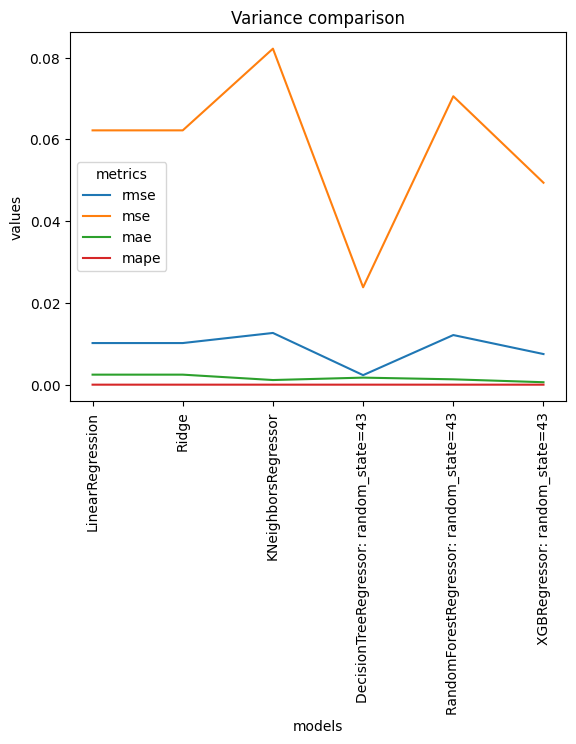

In [75]:
# Se visualiza la varianza entre los "folds"
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'mae', 'mape')


### Final

#### Preparación

In [84]:
# Se hace lo que en la prueba, pero con todos los barrios, y se guardan los dataframes resultantes en un dicccionario
warnings.filterwarnings("ignore")

dict_df = dict()
for col in df_acoustics.columns:
    df_uno = df_acoustics[[col]]
    df_uno = df_uno.rename(columns={col: 'x'})
    n = len(df_uno)
    for i in range(n+1):
        df_uno[f'x-{i}'] = df_uno['x'].shift(i)
    df_uno = df_uno.sort_index(ascending=False)
    df_uno = df_uno.drop(columns='x-0')
    df_uno_shortened = df_uno[df_uno.columns[:8]].dropna()
    dict_df[col] = df_uno_shortened

dict_df[1].head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7
date,,,,,,,,
2023-03-20,58.5,59.0,60.6,62.0,62.0,61.9,61.3,61.0
2023-03-19,59.0,60.6,62.0,62.0,61.9,61.3,61.0,60.3
2023-03-18,60.6,62.0,62.0,61.9,61.3,61.0,60.3,61.6
2023-03-17,62.0,62.0,61.9,61.3,61.0,60.3,61.6,62.2
2023-03-16,62.0,61.9,61.3,61.0,60.3,61.6,62.2,62.9


#### Hiperparámetros

In [ ]:

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42]
}

# Define the DecisionTreeRegressor model
dtr = DecisionTreeRegressor()

# Define the randomized search with 10-fold cross-validation
rs = RandomizedSearchCV(dtr, param_distributions=param_grid, n_iter=10, cv=kfolds, random_state=42)
